In [1]:
# Core imports
import numpy as np
import os
import torch
import yaml
import random
import pandas as pd
from collections import Counter

# DAART imports
from daart.data import DataGenerator
from daart.transforms import ZScore
from daart.models import Segmenter

# Science imports
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib as mpl
# plt.style.use('dark_background')

# Video imports
import seaborn as sns
from IPython.display import HTML
import cv2

# IBL imports
import ibllib.io.video as vidio
from brainbox.io.one import SessionLoader
from one.api import ONE
# Connect to the IBL database
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')
pd.set_option('display.max_rows', 500)

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [2]:
#@config
l_thresh = 0.0
view = 'left'
paw = 'paw_r'

In [3]:
#@static variables
eid_inferred = 'db4df448-e449-4a6f-a0e7-288711e7a75a'
preds = np.load("./stores/state_preds.npy") # (5, 208000)

state_labels = ['Still', 'Move', 'Wheel Turn', 'Groom']
state_keys = {1: 'Still', 2: 'Move', 3: 'Wheel Turn', 4: 'Groom'}
states = ['Still', 'Move', 'Wheel Turn', 'Groom']
colors = ['red', 'blue', 'green', 'purple']
state_map = np.vectorize(lambda x: state_keys[x])

vid_url = vidio.url_from_eid(eid_inferred, one=one)[view]
cap = cv2.VideoCapture(vid_url)
fps = cap.get(cv2.CAP_PROP_FPS)

def get_video_frames(start, end):
    
    # read the video frames
    cap = cv2.VideoCapture(vid_url)

    our_frames = []
    for i in range(0, end):
        ret, frame = cap.read()
        if i >= start:
            our_frames.append(frame)

    # Release the VideoCapture object
    cap.release()
    return np.array(our_frames)

frame = get_video_frames(1000,1001)[0]

In [4]:
# Function to extract and/or smooth ibl data
def extract_marker_data(eid, l_thresh, view, paw):
    #sess_id = dropbox_marker_paths[eid]

    # Load the pose data
    sl = SessionLoader(one=one, eid=eid)
    sl.load_pose(likelihood_thr=l_thresh, views=[view])
    times = sl.pose[f'{view}Camera'].times.to_numpy()
    markers = sl.pose[f'{view}Camera'].loc[:, (f'{paw}_x', f'{paw}_y')].to_numpy()

    # Load wheel data
    sl.load_wheel()
    wh_times = sl.wheel.times.to_numpy()
    wh_vel_oversampled = sl.wheel.velocity.to_numpy()
    
    # Resample wheel data at marker times
    interpolator = interp1d(wh_times, wh_vel_oversampled, fill_value='extrapolate')
    wh_vel = interpolator(times)

    # Process the data
    markers_comb = np.hstack([markers, wh_vel[:, None]])
    velocity = np.vstack([np.array([0, 0, 0]), np.diff(markers_comb, axis=0)])
    markers_comb = np.hstack([markers_comb, velocity])
    feature_names = ['paw_x_pos', 'paw_y_pos', 'wheel_vel', 'paw_x_vel', 'paw_y_vel', 'wheel_acc']
    df = pd.DataFrame(markers_comb, columns=feature_names)
    return df, times

In [5]:
marker_data, cam_times = extract_marker_data(eid_inferred, l_thresh, view, paw)

/home/nuttidalab/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


In [6]:
data_df = marker_data.iloc[:208000, :].copy()

# Calculate the ensemble mode for each frame across the models
ensemble_mode = stats.mode(preds, axis=0).mode

# Calculate variance for each frame across the models
ensemble_variance = stats.variation(preds, axis=0)

# calculate the paw speed
data_df['paw_speed'] = np.sqrt(data_df['paw_x_vel']**2 + data_df['paw_y_vel']**2)

# calculate the wheel speed
data_df['wheel_speed'] = data_df['wheel_vel'].abs()

# Add the inferred states to the data
preds_labelled = state_map(preds)
for i in range(0, 5):
    data_df[f'mod_{i+1}'] = preds_labelled[i]

# add them all do the data frame
data_df['e_mode'] = state_map(ensemble_mode)
data_df['e_var'] = ensemble_variance
data_df['frame_id'] = np.arange(0, len(data_df))

# Put camera times in there
data_df['cam_times'] = cam_times[:208000]

# organize the columns:
cols = ['paw_x_pos', 'paw_y_pos', 'paw_x_vel', 'paw_y_vel', 'paw_speed',
        'wheel_vel', 'wheel_speed', 'wheel_acc', 'cam_times',
        'mod_1', 'mod_2', 'mod_3', 'mod_4', 'mod_5', 'e_mode', 'e_var', 'frame_id']

####################
# Silencing the +-5 frames around the transitions
model_to_use = 'e_mode'
any_transition_frames = data_df[
    (data_df[model_to_use].shift() != data_df[model_to_use])
].index

silence_window = 5
# Make it so that +- 5 frames around the transition frames are also set to 0
for noise_frame in any_transition_frames:
    data_df.loc[noise_frame - silence_window:noise_frame + silence_window, 'e_var'] = 0
####################

# reorder the columns
data_df = data_df[cols]

data_df.round(2)

,paw_x_pos,paw_y_pos,paw_x_vel,paw_y_vel,paw_speed,wheel_vel,wheel_speed,wheel_acc,cam_times,mod_1,mod_2,mod_3,mod_4,mod_5,e_mode,e_var,frame_id
0,340.48,340.09,0.00,0.00,0.00,0.0,0.0,0.0,21.53,Groom,Groom,Groom,Groom,Groom,Groom,0.0,0
1,343.87,340.09,3.40,0.00,3.40,0.0,0.0,0.0,21.54,Groom,Groom,Groom,Groom,Groom,Groom,0.0,1
2,345.93,340.09,2.05,0.00,2.05,0.0,0.0,0.0,21.56,Groom,Groom,Groom,Groom,Groom,Groom,0.0,2
3,345.93,338.45,0.00,-1.64,1.64,0.0,0.0,0.0,21.58,Groom,Groom,Groom,Groom,Groom,Groom,0.0,3
4,347.36,338.45,1.43,0.00,1.43,0.0,0.0,0.0,21.59,Groom,Groom,Groom,Groom,Groom,Groom,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207995,536.37,648.28,0.01,0.01,0.01,0.0,0.0,0.0,3484.25,Still,Still,Still,Still,Still,Still,0.0,207995
207996,536.41,648.32,0.04,0.03,0.05,0.0,0.0,-0.0,3484.27,Still,Still,Still,Still,Still,Still,0.0,207996
207997,536.45,648.36,0.04,0.04,0.06,0.0,0.0,-0.0,3484.28,Still,Still,Still,Still,Still,Still,0.0,207997
207998,536.45,648.36,0.00,0.00,0.00,0.0,0.0,0.0,3484.30,Still,Still,Still,Still,Still,Still,0.0,207998


## Paw positions

In [52]:

def plot_paws_and_speed(gs, fig, cbar = True):

    ############# LOCATION #############
    ax_paws = [(0, 0), (0, 1), (0, 2), (0, 3)]    # Axis for the Paws
    ############# LOCATION #############

    frame_marker_df = data_df.copy()

    sl = SessionLoader(one=one, eid=eid_inferred)
    sl.load_pose(likelihood_thr=l_thresh, views=[view])
    marker_px = sl.pose[f'{view}Camera'].loc[:, (f'{paw}_x', f'{paw}_y')].to_numpy()[:frame_marker_df.shape[0], :].T

    frame_marker_df['paw_x_pos'] = marker_px[0]
    frame_marker_df['paw_y_pos'] = marker_px[1]
    frame_marker_df['paw_speed_normalized'] = np.clip(frame_marker_df['paw_speed']*9, 0, 30)

    states = state_labels # ['Still', 'Move', 'Wheel Turn', 'Groom']


    # for ax, state in zip(axs.flatten(), states):
    for i, (row, col) in enumerate(ax_paws):
        
        ax = fig.add_subplot(gs[row, col])
        state = states[i]

        # Filter data for the current state
        state_data = frame_marker_df[frame_marker_df['e_mode'] == state]
        
        # Plot the base frame
        ax.imshow(frame)
        
        # Overlay points with alpha based on speed
        sc = ax.scatter(
            state_data['paw_x_pos'],
            state_data['paw_y_pos'],
            c=state_data['paw_speed_normalized'],
            cmap="plasma",
            alpha=1,
            marker='+',
            s=0.1,  # Marker size
            label=f'{state} paw positions'
        )
        
        ax.set_title(f"Paw Positions: {state}")
        ax.axis('off')  # Hide axes for better visualization

    cbar_ax = fig.add_subplot(gs[0, 4])
    cbar_ax.axis('off')
    if cbar:
        # cbar = mpl.colorbar.ColorbarBase(cbar_ax, orientation='vertical', cmap='plasma',location='left')
        cbar = fig.colorbar(sc, ax=cbar_ax, orientation='vertical', location='right', fraction=0.99)
        cbar.set_label("Paw Speed")
        cbar.set_ticks([0, 6, 12, 18, 24, 30])
        cbar.set_ticklabels([0, 6, 12, 18, 24, "*30+"])
        cbar.ax.yaxis.set_label_position('left')

    # plt.suptitle("Paw Positions (and speed)", fontsize=12)

# plt.show()

## Duration histograms

In [8]:
sd_df = data_df[["e_mode", "cam_times", "frame_id"]].copy()

# Step 1: Identify continuous state segments
sd_df['group'] = (sd_df['e_mode'] != sd_df['e_mode'].shift()).cumsum()

# Step 2: Calculate the duration of each frame
sd_df['frame_duration'] = sd_df['cam_times'].shift(-1) - sd_df['cam_times']

# Handle the NaN value for the last frame (no next frame to subtract)
sd_df['frame_duration'] = sd_df['frame_duration'].fillna(1/60)

# Step 3: Sum frame durations within each group to get state durations
durations = sd_df.groupby('group').agg(
    e_mode=('e_mode', 'first'),
    duration=('frame_duration', 'sum')
).reset_index(drop=True)

In [9]:
def plot_state_durations(gs, fig):
    ############# LOCATION #############
    ax_durations = [(1, 0), (1, 1), (1, 2), (1, 3)]
    ############# LOCATION #############

    # Step 4: Plot histograms for each 'e_mode' state
    # for idx, ax in enumerate(axs.flatten()):
    for idx, (row, col) in enumerate(ax_durations):

        ax = fig.add_subplot(gs[row, col])

        state_data = durations[durations['e_mode'] == states[idx]]['duration']

        # ax.hist(state_data, bins=50, edgecolor='white', linewidth=0.5, color=colors[idx])
        sns.histplot(state_data, bins=50, color=colors[idx], ax=ax, log_scale=(True, False), fill=True)
        ax.set_title(f'Durations of {states[idx]}')
        ax.set_xlabel('Duration (seconds)')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')

In [28]:
def plot_tot_duration(gs, fig):

    # combine the state durations with themselves and make bargraphs

    # Step 1: Calculate the total duration per state
    total_durations = durations.groupby('e_mode')['duration'].sum().reset_index()

    # Optional: Sort the states by total duration (descending order)
    total_durations.sort_values('duration', ascending=False, inplace=True)

    states = state_labels
    color_map = {state: color for state, color in zip(states, colors)}
    total_durations['color'] = total_durations['e_mode'].map(color_map)

    # fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    ax = fig.add_subplot(gs[0, 5:7])

    cols = total_durations['color'].tolist()
    bp = sns.barplot(data=total_durations, x='e_mode', y='duration', hue='e_mode', palette=cols, ax=ax, legend=True)

    # Add labels to the top of each bar
    # for bar in bp.patches:
    #     bar_height = bar.get_height()
    #     bar_x = bar.get_x() + bar.get_width() / 2
    #     ax.text(bar_x, bar_height, f'{round(bar_height, 2):.2f}', ha='center', va='bottom', fontsize=8)
    for i in bp.containers:
        bp.bar_label(i,)


    bp.get_legend().set_title('State')
    ax.set_title('Total Duration per State')
    # ax.set_xlabel('State')
    # set xlabel off
    ax.set_xlabel('')
    ax.set_ylabel('Total Duration (seconds)')
    # ax.yaxis.tick_right()
    # ax.yaxis.set_label_position("right")
    bp.set_yscale('log')

    # plt.show()

## Ethograms stacked

In [11]:
ct = data_df["cam_times"]
tr = one.load_object(eid_inferred, 'trials')

interval_df = pd.DataFrame(tr['intervals'], columns=['start', 'end'])
interval_df["frame_start"] = np.searchsorted(ct, interval_df["start"]).astype(int)
interval_df["frame_end"] = np.searchsorted(ct, interval_df["end"]).astype(int)
interval_df["firstMovement_times"] = tr["firstMovement_times"]
interval_df["frame_fmt"] = np.searchsorted(ct, interval_df["firstMovement_times"])
interval_df["stimOn_times"] = tr["stimOn_times"]
interval_df["stimOff_times"] = tr["stimOff_times"]
interval_df["feedback_times"] = tr["feedback_times"]
interval_df["trial_idx"] = np.arange(0, len(interval_df))

In [12]:
# from data_df, e_var column, calculate the average variance within the frame_start and frame_end
def calculate_avg_var(row):
    # Ensure frame_start and frame_end are valid integers
    frame_start = max(0, int(row["frame_start"]))
    frame_end = min(len(data_df) - 1, int(row["frame_end"]))  # Ensure within bounds
    # Return the mean of e_var for the valid range
    return data_df["e_var"].iloc[frame_start:frame_end].mean()

# Apply the function to calculate avg_var
interval_df["avg_var"] = interval_df.apply(calculate_avg_var, axis=1)

def make_raster_data(some_df):
    # temporary holder for the data
    ens_raster_holder = np.zeros((len(some_df), (some_df["frame_end"] - some_df["frame_start"]).max()))
    ens_raster_holder[:] = np.nan
    var_raster_holder = np.zeros_like(ens_raster_holder)
    var_raster_holder[:] = np.nan

    for idx, row in some_df.iterrows():
        # start = int(row["frame_start"])
        previous_space = 20
        start = int(row["frame_fmt"])
        end = int(row["frame_end"])
        class_to_int = {label: i for i, label in enumerate(state_labels)}
        ens_raster_holder[idx, :end - start + previous_space] = data_df["e_mode"][start - previous_space:end].map(class_to_int).values
        var_raster_holder[idx, :end - start + previous_space] = data_df["e_var"][start - previous_space:end].values

    return ens_raster_holder, var_raster_holder, some_df["trial_idx"].values + 1

def plot_raster(er, vr, correct_info, gs, fig, yticks = None, xlim = 120, title = "Rasters of Trials over Time"):
    # plt.style.use('default')
    colors = ['red', 'blue', 'green', 'purple']
    cmap = ListedColormap(colors)

    # fig, axs = plt.subplots(1,3, figsize=(20, 10), dpi=300)

    choice_ax = fig.add_subplot(gs[1:5, 4])
    ens_ax = fig.add_subplot(gs[1:5, 5:7])
    var_ax = fig.add_subplot(gs[1:5, 7:9])

    # Convert frames to seconds
    x_ticks = np.linspace(-20 / fps, (xlim - 20) / fps, 10)  # 10 ticks, starting from -20 frames


    # Binary information axis
    binary_cmap = ListedColormap(['red', 'green'])  # Red for wrong, green for correct
    binary_data = np.expand_dims(correct_info, axis=1)  # Reshape for heatmap
    sns.heatmap(binary_data, cmap=binary_cmap, cbar=False, ax=choice_ax)
    # choice_ax.set_title("Mouse Correctness")
    choice_ax.set_xticks([])  # Remove x-axis
    choice_ax.set_yticks([] if yticks is None else np.arange(len(yticks)))
    choice_ax.set_yticklabels([] if yticks is None else yticks, fontsize=5, rotation=0)
    choice_ax.set_ylabel("Rewards")


    sns.heatmap(er, cmap=cmap, cbar=False, ax=ens_ax)
    ens_ax.set_title("Raster of Ensemble Mode States")
    ens_ax.set_xlabel("Time from first movement onset (s)")
    ens_ax.set_ylabel("Trial #")
    ens_ax.set_xlim(0, xlim)
    # ens_ax.set_xticks(np.arange(0, xlim, max(1, xlim // 10)))
    # ens_ax.set_xticklabels(np.arange(0, xlim, max(1, xlim // 10)))
    
    # Set ticks and labels
    ens_ax.set_xticks(np.linspace(0, xlim, 10))  # 10 evenly spaced ticks
    ens_ax.set_xticklabels([f"{tick:.2f}s" for tick in x_ticks], rotation = 0)  # Format as seconds

    # vertical line at 20 for first movement onset
    ens_ax.axvline(x=20, color='black', linestyle='--')

    ens_ax.legend([
        Line2D([0], [0], marker='.', color='w', markerfacecolor='red', markersize=15),
        Line2D([0], [0], marker='.', color='w', markerfacecolor='blue', markersize=15),
        Line2D([0], [0], marker='.', color='w', markerfacecolor='green', markersize=15),
        Line2D([0], [0], marker='.', color='w', markerfacecolor='purple', markersize=15),
        Line2D([0], [0], linestyle="--", color='k', markerfacecolor='black', markersize=15)
        ],
        ['Still', 'Move', 'Wheel Turn', 'Groom', 'First Movement Onset'], loc='upper right', frameon=True)

    sns.heatmap(vr, cmap="rocket", cbar=True, ax=var_ax, cbar_kws={"aspect": 100, "shrink": 1, "pad": 0.01})
    # sns.heatmap(vr, cmap="rocket", cbar=True, ax=var_ax,)
    var_ax.set_title("Raster of Ensemble Mode Variance")
    var_ax.set_xlabel("Time from first movement onset (s)")
    var_ax.set_ylabel("Trial #")
    var_ax.set_xlim(0, xlim)
    # var_ax.set_xticks(np.arange(0, xlim, max(1, xlim // 10)))
    # var_ax.set_xticklabels(np.arange(0, xlim, max(1, xlim // 10)))

    # Set ticks and labels
    var_ax.set_xticks(np.linspace(0, xlim, 10))  # 10 evenly spaced ticks
    var_ax.set_xticklabels([f"{tick:.2f}s" for tick in x_ticks], rotation=0)  # Format as seconds

    if yticks is not None:
        # Set yticks and labels for ensemble raster
        ens_ax.set_yticks(np.arange(len(yticks)))
        ens_ax.set_yticklabels(yticks, rotation=0, fontsize=5)

        # Set yticks and labels for variance raster
        var_ax.set_yticks(np.arange(len(yticks)))
        var_ax.set_yticklabels(yticks, rotation=0, fontsize=5)

## Wheel speed

In [13]:
model_to_use = 'e_mode'
frame_counter_duration = 20

# Add a column to track when the state changes
data_df['state_change'] = (data_df[model_to_use] != data_df[model_to_use].shift()).cumsum()

# Compute the duration of each state block
data_df['state_duration'] = data_df.groupby('state_change').cumcount() + 1

# Reverse duration for the next state (counting backward)
data_df['state_duration_next'] = data_df[::-1].groupby('state_change').cumcount() + 1
# Ensure the previous state lasted at least 10 frames and the next state will last at least 10 frames
still_to_wheel_turn_frames = data_df[
    (data_df[model_to_use].shift() == 'Still') & 
    (data_df[model_to_use] == 'Wheel Turn') & 
    (data_df['state_duration'].shift() >= frame_counter_duration) & 
    (data_df['state_duration_next'] >= frame_counter_duration)
].index

wheel_turn_to_still_frames = data_df[
    (data_df[model_to_use].shift() == 'Wheel Turn') & 
    (data_df[model_to_use] == 'Still') & 
    (data_df['state_duration'].shift() >= frame_counter_duration) & 
    (data_df['state_duration_next'] >= frame_counter_duration)
].index

still_to_move_frames = data_df[
    (data_df[model_to_use].shift() == 'Still') & 
    (data_df[model_to_use] == 'Move') & 
    (data_df['state_duration'].shift() >= frame_counter_duration) & 
    (data_df['state_duration_next'] >= frame_counter_duration)
].index

move_to_still_frames = data_df[
    (data_df[model_to_use].shift() == 'Move') & 
    (data_df[model_to_use] == 'Still') & 
    (data_df['state_duration'].shift() >= frame_counter_duration) & 
    (data_df['state_duration_next'] >= frame_counter_duration)
].index

In [14]:
# Extract transition data with -50 to +100 frames around transitions
def extract_transition_data_with_window(frames, data, data_col, pre_window=30, post_window=50):
    transition_data = []
    for frame in frames:
        if frame - pre_window >= 0 and frame + post_window < len(data):  # Ensure bounds
            transition_data.append(data.iloc[frame - pre_window:frame + post_window][data_col].values)
    return np.array(transition_data)


In [15]:
def plot_wheel_speed(gs, fig):

    still_to_wheel_turn_data = extract_transition_data_with_window(still_to_wheel_turn_frames, data_df, data_col="wheel_speed")
    wheel_turn_to_still_data = extract_transition_data_with_window(wheel_turn_to_still_frames, data_df, data_col="wheel_speed")

    still_to_wheel_turn_avg = still_to_wheel_turn_data.mean(axis=0)
    wheel_turn_to_still_avg = wheel_turn_to_still_data.mean(axis=0)

    ax1 = fig.add_subplot(gs[2, 0:2])
    ax2 = fig.add_subplot(gs[2, 2:4])

    x = np.arange(-30,50,1)  # 100 frames
    # convert it to seconds using the frame rate
    x = x / fps
    alpha = 0.2

    for line in still_to_wheel_turn_data:
        ax1.plot(x, line, color="gray", alpha=alpha)
    ax1.plot(x, still_to_wheel_turn_avg, "k--", label="Still → Wheel Turn", linewidth=2)

    for line in wheel_turn_to_still_data:
        ax2.plot(x, line, color="gray", alpha=alpha)
    ax2.plot(x, wheel_turn_to_still_avg, "k--", label="Wheel Turn → Still", linewidth=2)

    for a in [ax1, ax2]:
        # a.set_title("Wheel Speed Transitions")
        a.set_xlabel("Time from Transition (seconds)")
        a.set_ylabel("Wheel Speed")
        a.legend(loc='upper right')
        a.grid()

    # plt.suptitle("Wheel Speed Conditioned on Transitions", fontsize=16)

## Paw speed

In [16]:
def plot_paw_speed(gs, fig):

    still_to_wheel_turn_data = extract_transition_data_with_window(still_to_wheel_turn_frames, data_df, data_col="paw_speed")
    wheel_turn_to_still_data = extract_transition_data_with_window(wheel_turn_to_still_frames, data_df, data_col="paw_speed")
    still_to_move_data = extract_transition_data_with_window(still_to_move_frames, data_df, data_col="paw_speed")
    move_to_still_data = extract_transition_data_with_window(move_to_still_frames, data_df, data_col="paw_speed")

    still_to_wheel_turn_avg = still_to_wheel_turn_data.mean(axis=0)
    wheel_turn_to_still_avg = wheel_turn_to_still_data.mean(axis=0)
    still_to_move_avg = still_to_move_data.mean(axis=0)
    move_to_still_avg = move_to_still_data.mean(axis=0)

    ax = fig.add_subplot(gs[3, 0:4])

    x = np.arange(-30,50,1)
    x = x / fps

    lines = [still_to_wheel_turn_avg, wheel_turn_to_still_avg, still_to_move_avg, move_to_still_avg]

    for i, line_name in enumerate(["Still → Wheel Turn", "Wheel Turn → Still", "Still → Move", "Move → Still"]):
        ax.plot(x, lines[i], label=line_name)

    ax.axvline(0, color='k', linestyle='--', label="State Transition")  # Highlight transition frame
    ax.set_xlabel("Time from Transition (s)")
    ax.set_ylabel("Paw Speed")
    ax.legend()
    ax.grid()

## Hist of ens-var

In [17]:
def plt_ens_var_hist(gs, fig):

    ax = fig.add_subplot(gs[0, 7:9])

    ax = sns.histplot(data_df["e_var"], bins=50, color='k', log_scale=False, fill=True)
    ax.set_title("Variance Distribution")
    ax.set_xlabel("Variance")
    ax.set_xlim(0, 1)
    ax.set_ylabel("Frequency")
    ax.set_yscale('log')

## Main

In [37]:
# Function to leave other subplots empty
def leave_axes_empty(gs, fig):
    for row in range(5):
        for col in range(9):
            ax = fig.add_subplot(gs[row, col])
            ax.set_xticks([])  # Remove ticks for empty subplots
            ax.set_yticks([])
            ax.set_frame_on(True)  # Keep the frame for visual alignment

/home/nuttidalab/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:543: ALFWarning: Multiple revisions: "", "2023-04-20"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


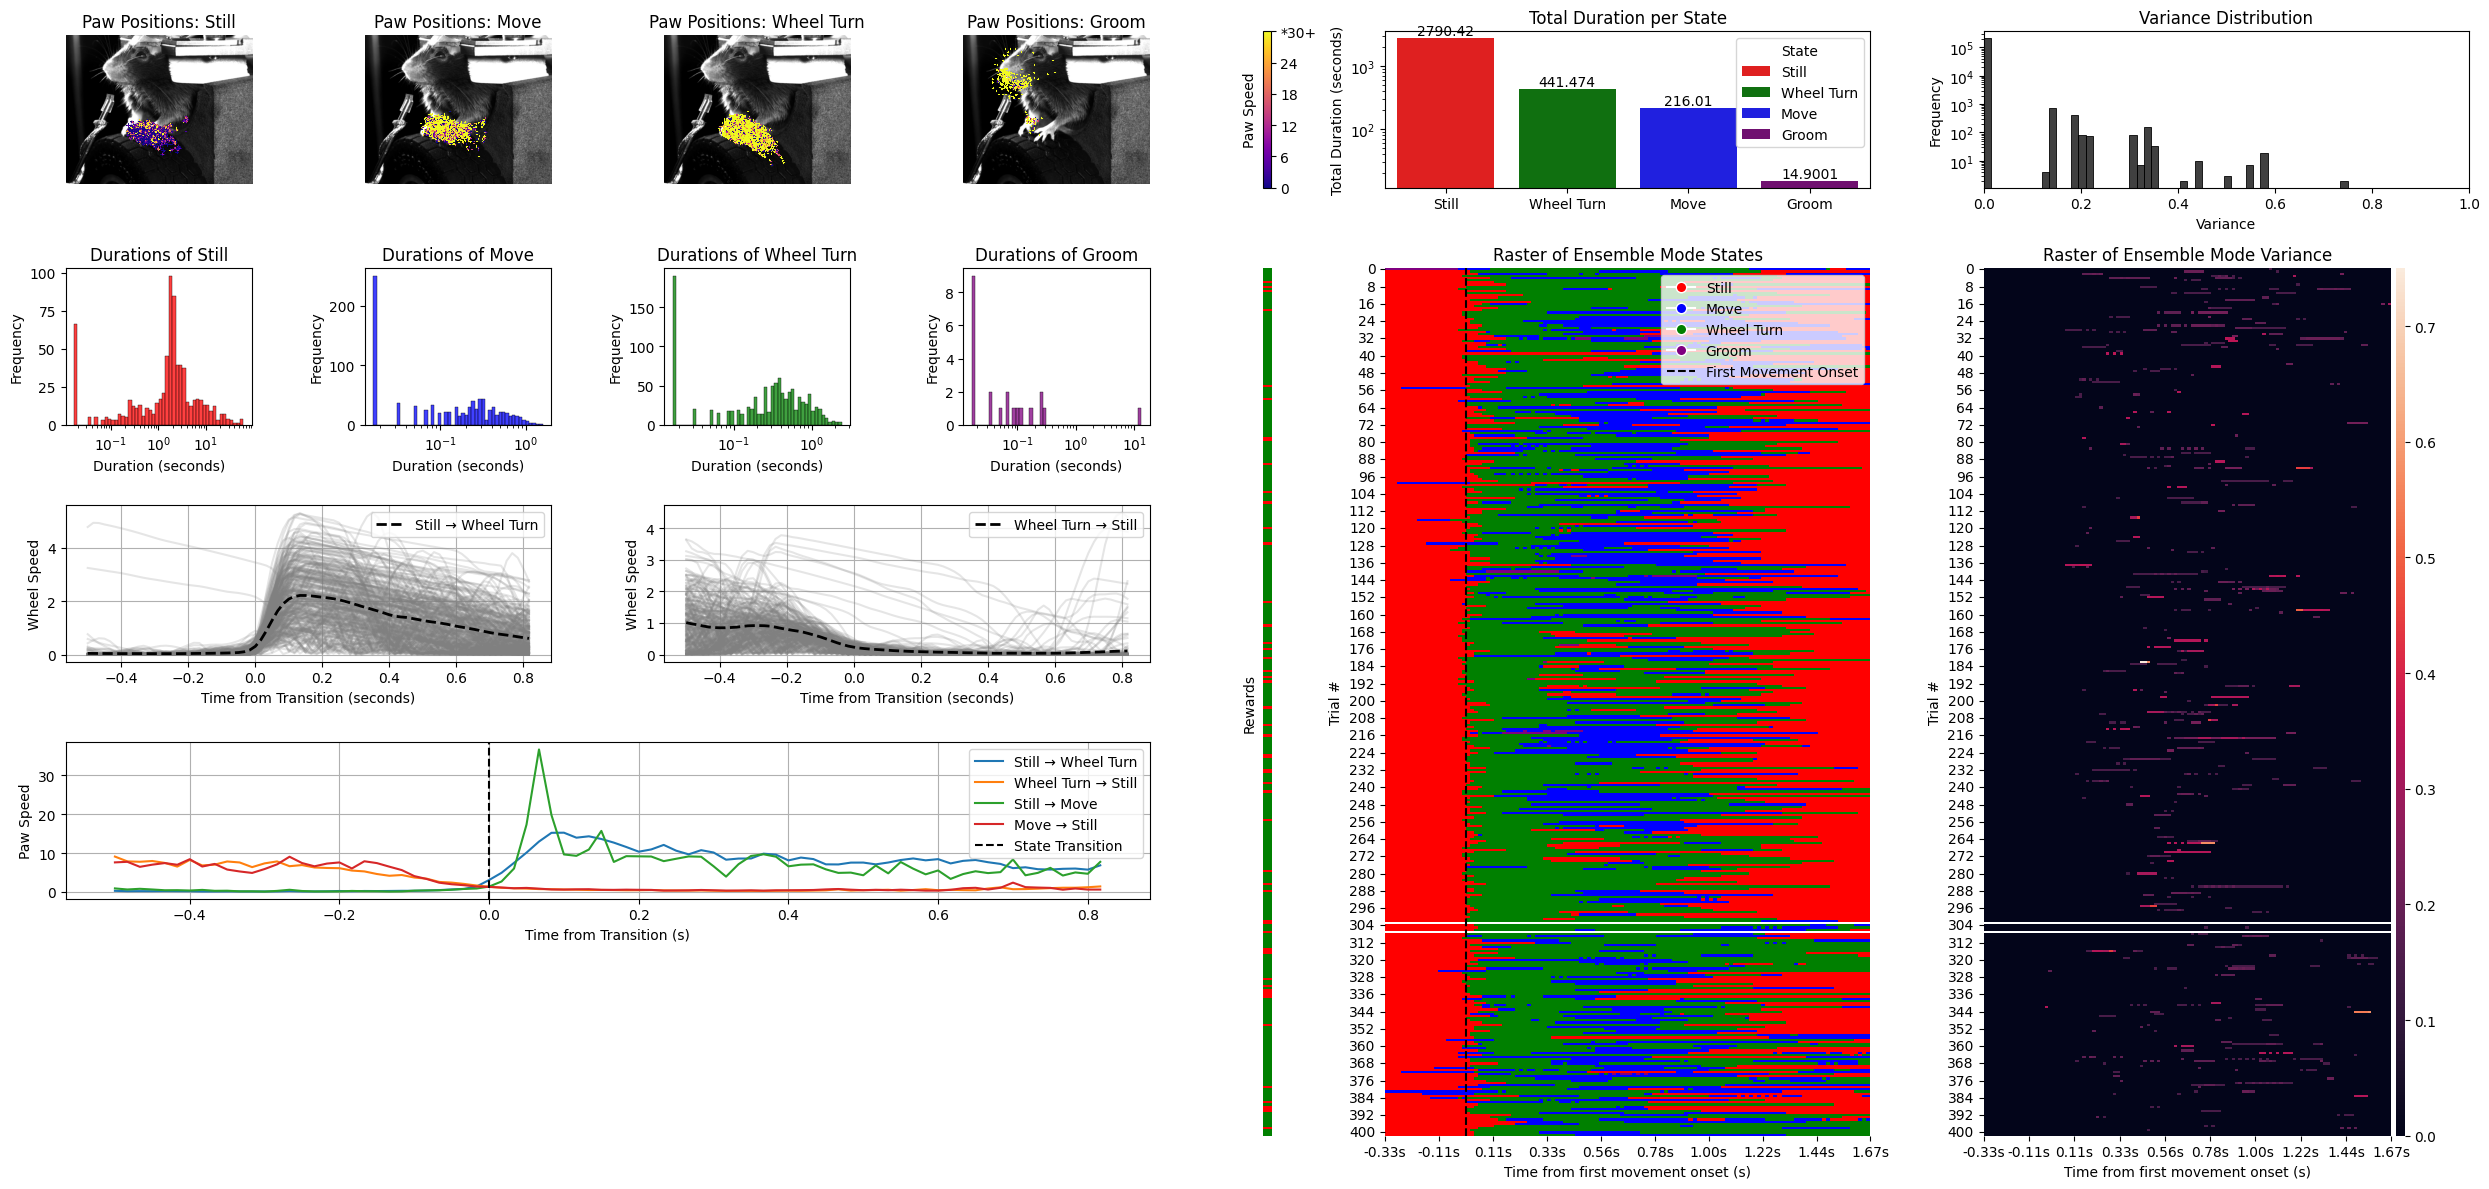

In [54]:
# Main function to set up the grid
def create_grid():
    fig = plt.figure(figsize=(25, 12))  # Adjust the figure size as needed
    gs = gridspec.GridSpec(5, 9, figure=fig, width_ratios=[1, 1, 1, 1, 0.05, 1, 1, 1, 1])  # Create an 8x4 grid
    
    # Leave the rest of the axes empty
    # leave_axes_empty(gs, fig)

    # Plot the paws and speed
    plot_paws_and_speed(gs, fig)

    plot_state_durations(gs, fig)

    plot_tot_duration(gs, fig)

    ens_raster, var_raster, trial_idx = make_raster_data(interval_df)
    choice_data = (tr["feedbackType"]+ 1)/ 2
    plot_raster(ens_raster[:], var_raster[:], choice_data, gs, fig)

    plot_wheel_speed(gs, fig)

    plot_paw_speed(gs, fig)

    plt_ens_var_hist(gs, fig)

    plt.tight_layout()
    plt.show()

# Call the main function
create_grid()

In [56]:
SessionLoader(one=one, eid=eid_inferred)

SessionLoader(one=One (online, https://openalyx.internationalbrainlab.org), session_path=PosixPath('/home/nuttidalab/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_009/2020-02-27/001'), eid='db4df448-e449-4a6f-a0e7-288711e7a75a', revision='')